In [3]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import matplotlib.pyplot as plt


In [4]:
print(tf.__version__)

2.10.1


In [14]:
# set params
batch_size = 32
img_height = 100
img_width = 100
data_dir = './islahiye_0207_building_crops/'
AUTOTUNE = tf.data.AUTOTUNE

In [6]:
image_count = 10404 # this number should be extracted from xBD_data_processing.ipynb
list_ds = tf.data.Dataset.list_files((data_dir + '*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [7]:
# damaged_ds = tf.data.Dataset.list_files((data_dir + 'damaged/*'), shuffle=False)
# l1 = len(damaged_ds)
# print("Total number of available images in class 'damaged' is:", l1)
# undamaged_ds = tf.data.Dataset.list_files((data_dir + 'undamaged/*'), shuffle=False)
# l2 = len(undamaged_ds)
# print("Total number of available images in class 'undamaged' is:", l2)

In [8]:
# undamaged_ds = undamaged_ds.shuffle(l1, seed = 207).take(l1)
# image_count = l1*2
# list_ds = undamaged_ds.concatenate(damaged_ds)
# list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)
# # print("Total number of combined images after undersampling majority class is:", len(list_ds))

In [9]:
for f in list_ds.take(10):
    print(f.numpy())

b'.\\islahiye_0207_building_crops\\undamaged\\islahiye-4345-undamaged.png'
b'.\\islahiye_0207_building_crops\\undamaged\\islahiye-1647-undamaged.png'
b'.\\islahiye_0207_building_crops\\undamaged\\islahiye-1341-undamaged.png'
b'.\\islahiye_0207_building_crops\\undamaged\\islahiye-9084-undamaged.png'
b'.\\islahiye_0207_building_crops\\undamaged\\islahiye-5377-undamaged.png'
b'.\\islahiye_0207_building_crops\\undamaged\\islahiye-4743-undamaged.png'
b'.\\islahiye_0207_building_crops\\undamaged\\islahiye-1625-undamaged.png'
b'.\\islahiye_0207_building_crops\\undamaged\\islahiye-629-undamaged.png'
b'.\\islahiye_0207_building_crops\\undamaged\\islahiye-4697-undamaged.png'
b'.\\islahiye_0207_building_crops\\undamaged\\islahiye-8993-undamaged.png'


In [11]:
class_names = np.array(sorted([item for item in os.listdir(data_dir)]))
print(class_names)

['damaged' 'undamaged']


In [17]:
# tensorflow tutorial functions for manual creation of datasets
def get_label(file_path):
    # Convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    one_hot = parts[-2] == class_names
    # Integer encode the label
    return tf.argmax(one_hot)

def decode_img(img):
    # (FORMAT = PNG) convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_png(img, channels=3)
    # Resize the image to the desired size (WITH PAD)
    return tf.image.resize_with_pad(img, 100, 100)

def process_path(file_path):
    label = get_label(file_path)
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [35]:
# use this cell to split dataset into train, val, and test
val_size = int(image_count * 0.1)
test_size = int(image_count * 0.1)

train_ds = list_ds.skip(val_size + test_size)
val_ds = list_ds.take(val_size + test_size)

test_ds = val_ds.take(test_size)
val_ds = val_ds.skip(test_size)

In [ ]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

In [20]:
# use this cell to make all images for testing purposes only
test_ds = list_ds
test_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)

test_ds = configure_for_performance(test_ds)

In [21]:
for image, label in test_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (32, 100, 100, 3)
Label:  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


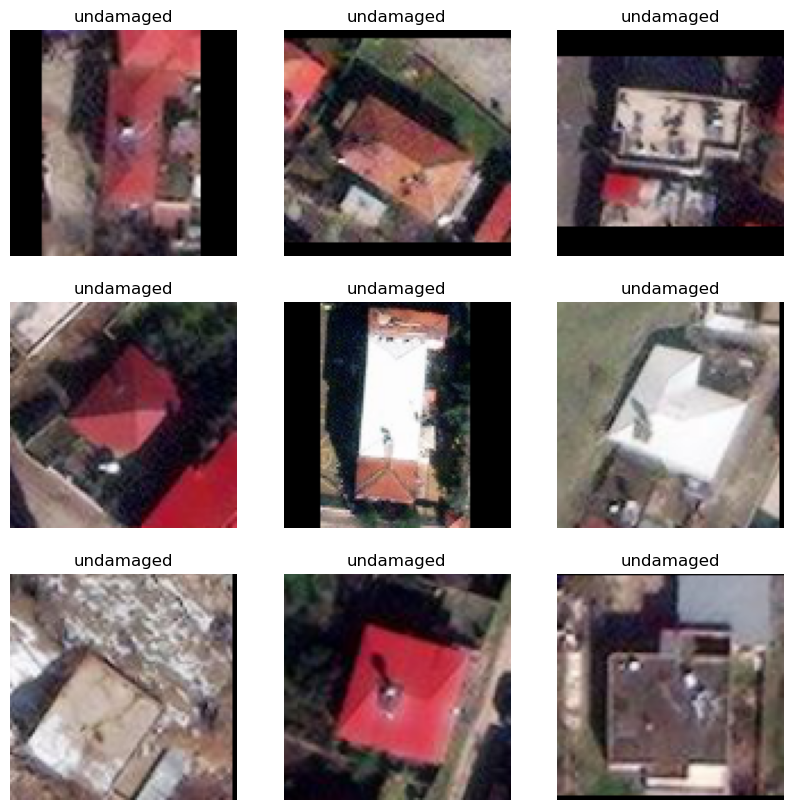

In [22]:
image_batch, label_batch = next(iter(test_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    plt.title(class_names[label])
    plt.axis("off")

In [42]:
# save the datasets
train_ds.save('turkey/train')
val_ds.save('turkey/val')

In [23]:
test_ds.save('turkey/test')